<a href="https://colab.research.google.com/github/Loinen/geodata_analysis/blob/main/lab2021.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# импорты
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

    TEMP - Mean temperature (.1 Fahrenheit)
    SLP - Mean sea level pressure for the day in millibars to tenths. Missing = 9999.9 (.1 mb)
    WDSP – Mean wind speed (.1 knots)

In [3]:
original_data = pd.read_csv("data/data_spb.csv", index_col=1, na_values='NA', usecols=['STATION', 'DATE', 'TEMP', 'SLP', 'WDSP'])
original_data

,STATION,SLP,TEMP,WDSP
DATE,,,,
1990-02-03,26060099999,1010.5,34.3,999.9
1990-02-13,26060099999,1002.7,31.8,5.8
1990-04-29,26060099999,1014.9,50.4,7.8
1990-01-01,26063099999,1020.3,27.5,7.0
1990-01-02,26063099999,1020.4,22.2,3.6
...,...,...,...,...
2019-12-31,26072099999,993.5,35.8,5.1
2020-01-01,26063099999,9999.9,33.1,9.1
2020-01-02,26063099999,9999.9,38.7,11.0


In [4]:
original_data = original_data.loc[original_data.STATION == 26063099999]
original_data = original_data.drop(columns='STATION')

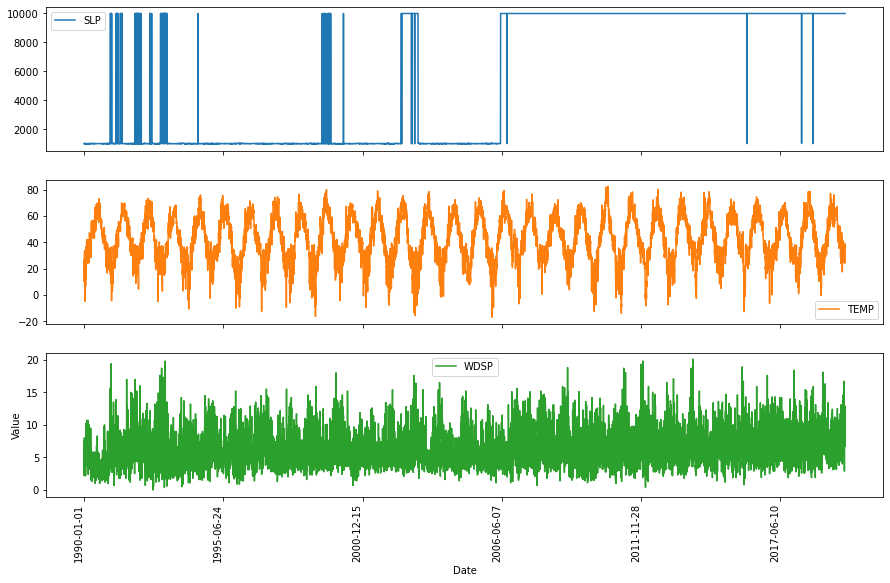

In [5]:
original_data.plot(subplots=True, figsize=(15, 10))
plt.ylabel("Value")
plt.xlabel("Date")
plt.legend(loc='best')
plt.xticks(rotation='vertical')
plt.show()
# we can see some gaps

In [6]:
# удаление пропущенных значений
data = original_data.copy()
missing_vals = data.loc[data.SLP==9999.9]
data = data.replace(9999.9, np.nan, regex=True)
data = data.dropna(subset=['SLP'])

X = data[['WDSP', 'TEMP']]
y = data[['SLP']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=13)

In [7]:
data.shape

(5516, 3)

In [8]:
missing_vals.shape

(5414, 3)

#Предсказание на данных без пропусков

In [9]:
# импользуем линейную регрессию
model = LinearRegression(normalize=True).fit(X_train,y_train)
predicted_del = model.predict(X_test)
predicted_del

array([[1015.97401872],
       [1020.17374332],
       [1012.41466516],
       ...,
       [1017.5995375 ],
       [1007.02192982],
       [1014.48281508]])

In [10]:
mae = mean_absolute_error(y_test, predicted_del)
mse = mean_squared_error(y_test, predicted_del)
print('Mean absolute error = ', mae)
print('Mean squared error = ', mse)

Mean absolute error =  8.398277124367771
Mean squared error =  114.79759068837514


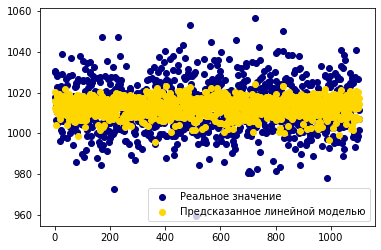

In [11]:
x = range(len(y_test))
plt.scatter(x, y_test, color='navy', label=u'Реальное значение')
plt.scatter(x, predicted_del, color='gold', label=u'Предсказанное линейной моделью')
plt.legend()
plt.show()

# Авторегрессия

In [13]:
from statsmodels.tsa.ar_model import AutoReg
from math import sqrt

In [16]:
temp = data['TEMP'].values

In [97]:
def autoreg(temp, prediction_size, window=600):
    X_train_autoreg, X_test_autoreg = temp[1:len(temp)-prediction_size], temp[len(temp)-prediction_size:]
    
    autoreg_model = AutoReg(X_train_autoreg, lags=window) # нужно добавить seasonal и период (посмотреть по Фурье)
    autoreg_model_fit = autoreg_model.fit()
    
    predictions = autoreg_model_fit.predict(start=len(X_train_autoreg), 
                                end=len(X_test_autoreg)+len(X_train_autoreg)-1, dynamic=True)
    
    rmse = sqrt(mean_squared_error(X_test_autoreg, predictions))
    mae = mean_absolute_error(X_test_autoreg, predictions)
    
    return predictions, rmse, mae

In [98]:
predictions, rmse, mae = autoreg(temp, 10, 600)

/home/tanya/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(


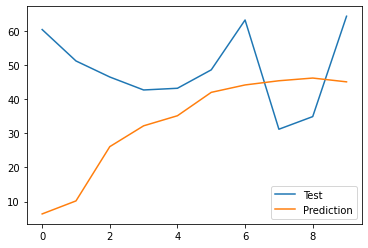

In [99]:
fig, ax = plt.subplots()

ax.plot(X_test_autoreg, label="Test")
ax.plot(predictions, label="Prediction")

ax.legend()
plt.show()

In [100]:
print("rmse", rmse)
print("mae", mae)

rmse 25.08574369771498
mae 20.42879564583697


/home/tanya/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(


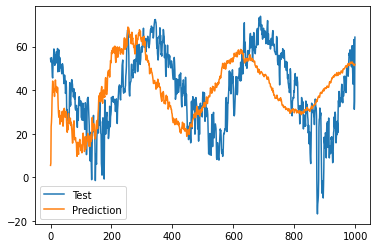

rmse 18.13941517148093
mae 15.293934026858233


In [107]:
pred_size = 1000
predictions, rmse, mae = autoreg(temp, pred_size, 500)

fig, ax = plt.subplots()

ax.plot(temp[len(temp)-pred_size:], label="Test")
ax.plot(predictions, label="Prediction")

ax.legend()
plt.show()

print("rmse", rmse)
print("mae", mae)

/home/tanya/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(


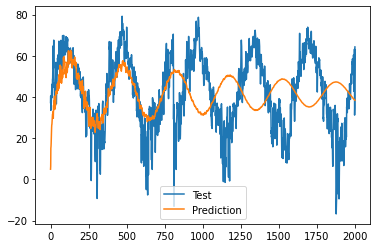

rmse 18.634161256182484
mae 14.80321230607741


In [109]:
pred_size = 2000
predictions, rmse, mae = autoreg(temp, pred_size, 400)

fig, ax = plt.subplots()

ax.plot(temp[len(temp)-pred_size:], label="Test")
ax.plot(predictions, label="Prediction")

ax.legend()
plt.show()

print("rmse", rmse)
print("mae", mae)

In [112]:
predictions_first = predictions[:600]
test_temp = temp[len(temp)-pred_size:]
test_temp = test_temp[:600]

rmse = sqrt(mean_squared_error(test_temp, predictions_first))
mae = mean_absolute_error(test_temp, predictions_first)

print("rmse", rmse)
print("mae", mae)

rmse 10.2963689537181
mae 7.913947857500182


# Вариант с 1 семестра (линейная регрессия)

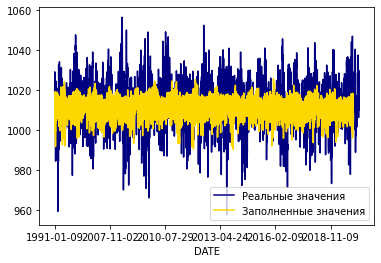

In [268]:
# заполнение пропусков лин регрессией
X_miss = missing_vals[['WDSP', 'TEMP']]
y_pred = model.predict(X_miss)

missing_vals['SLP'] = y_pred

data['SLP'].plot(color='navy', label='Реальные значения')
missing_vals['SLP'].plot(color='gold', label='Заполненные значения')
plt.legend()

In [269]:
train = pd.concat([X_train, y_train], axis=1)
filled_data = pd.concat([train, missing_vals])
filled_data = filled_data.sort_index()
new_X_train = filled_data[['WDSP', 'TEMP']]
new_y_train = filled_data[['SLP']]

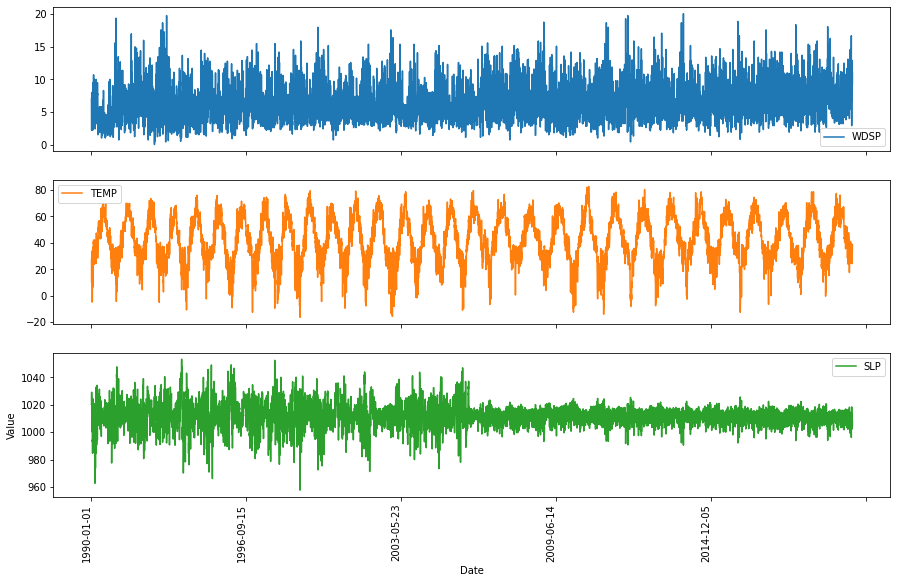

In [270]:
filled_data.plot(subplots=True, figsize=(15, 10))
plt.ylabel("Value")
plt.xlabel("Date")
plt.legend(loc='best')
plt.xticks(rotation='vertical')
plt.show()

In [271]:
model = LinearRegression(normalize=True).fit(new_X_train, new_y_train)
predicted_lr = model.predict(X_test)
predicted_lr

array([[1015.97401872],
       [1020.17374332],
       [1012.41466516],
       ...,
       [1017.5995375 ],
       [1007.02192982],
       [1014.48281508]])

In [272]:
mae = mean_absolute_error(y_test, predicted_lr)
mse = mean_squared_error(y_test, predicted_lr)
print('Mean absolute error = ', mae)
print('Mean squared error = ', mse) 

Mean absolute error =  8.39827712436777
Mean squared error =  114.79759068837511


# Медиана

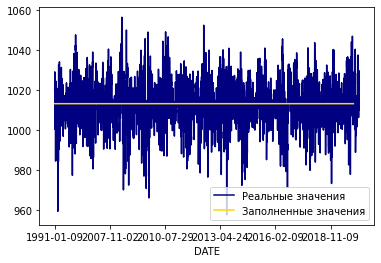

Mean absolute error =  8.491629969818478
Mean squared error =  120.02076846416911


In [273]:
missing_vals['SLP'] = train['SLP'].median()

data['SLP'].plot(color='navy', label='Реальные значения')
missing_vals['SLP'].plot(color='gold', label='Заполненные значения')
plt.legend()
plt.show()

train = pd.concat([X_train, y_train], axis=1)
filled_data = pd.concat([train, missing_vals])
filled_data = filled_data.sort_index()
new_X_train = filled_data[['WDSP', 'TEMP']]
new_y_train = filled_data[['SLP']]

# filled_data.plot(subplots=True, figsize=(15, 10))
# plt.ylabel("Value")
# plt.xlabel("Date")
# plt.legend(loc='best')
# plt.xticks(rotation='vertical')
# plt.show()

model = LinearRegression(normalize=True).fit(new_X_train, new_y_train)
predicted_lr = model.predict(X_test)
mae = mean_absolute_error(y_test, predicted_lr)
mse = mean_squared_error(y_test, predicted_lr)
print('Mean absolute error = ', mae)
print('Mean squared error = ', mse)

# Линейная интерполяция

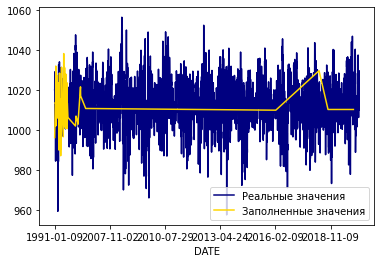

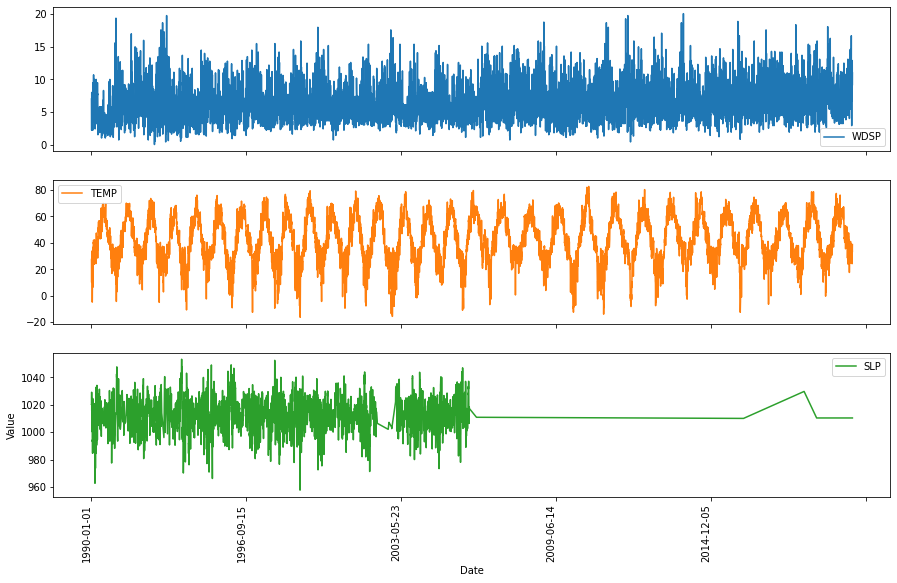

Mean absolute error =  8.478821167557255
Mean squared error =  119.96990261166191


In [274]:
missing2 = original_data.copy()
missing2 = missing2.replace(9999.9, np.nan, regex=True)

missing_interpolate = missing2[['SLP']].interpolate(method='linear')['SLP']
missing_vals['SLP'] = missing_interpolate

data['SLP'].plot(color='navy', label='Реальные значения')
missing_vals['SLP'].plot(color='gold', label='Заполненные значения')
plt.legend()
plt.show()

train = pd.concat([X_train, y_train], axis=1)
filled_data = pd.concat([train, missing_vals])
filled_data = filled_data.sort_index()
new_X_train = filled_data[['WDSP', 'TEMP']]
new_y_train = filled_data[['SLP']]

filled_data.plot(subplots=True, figsize=(15, 10))
plt.ylabel("Value")
plt.xlabel("Date")
plt.legend(loc='best')
plt.xticks(rotation='vertical')
plt.show()

model = LinearRegression(normalize=True).fit(new_X_train, new_y_train)
predicted_lr = model.predict(X_test)
mae = mean_absolute_error(y_test, predicted_lr)
mse = mean_squared_error(y_test, predicted_lr)
print('Mean absolute error = ', mae)
print('Mean squared error = ', mse)

In [275]:
original_data.shape

(10930, 3)

# Интерполяция сплайнами

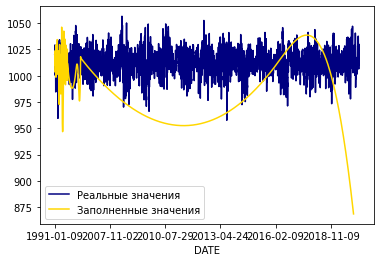

In [310]:
missing_spline = missing2.copy()
s = pd.Series(missing_spline["SLP"].values)

missing_spline['SLP'] = s.interpolate(method='spline', order=3).values
missing_vals['SLP'] = missing_spline

data['SLP'].plot(color='navy', label='Реальные значения')
missing_vals['SLP'].plot(color='gold', label='Заполненные значения')
plt.legend()
plt.show()

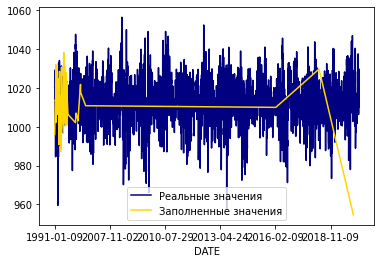

In [312]:
missing_spline = missing2.copy()
s = pd.Series(missing_spline["SLP"].values)

missing_spline['SLP'] = s.interpolate(method='spline', order=1).values
missing_vals['SLP'] = missing_spline

data['SLP'].plot(color='navy', label='Реальные значения')
missing_vals['SLP'].plot(color='gold', label='Заполненные значения')
plt.legend()
plt.show()

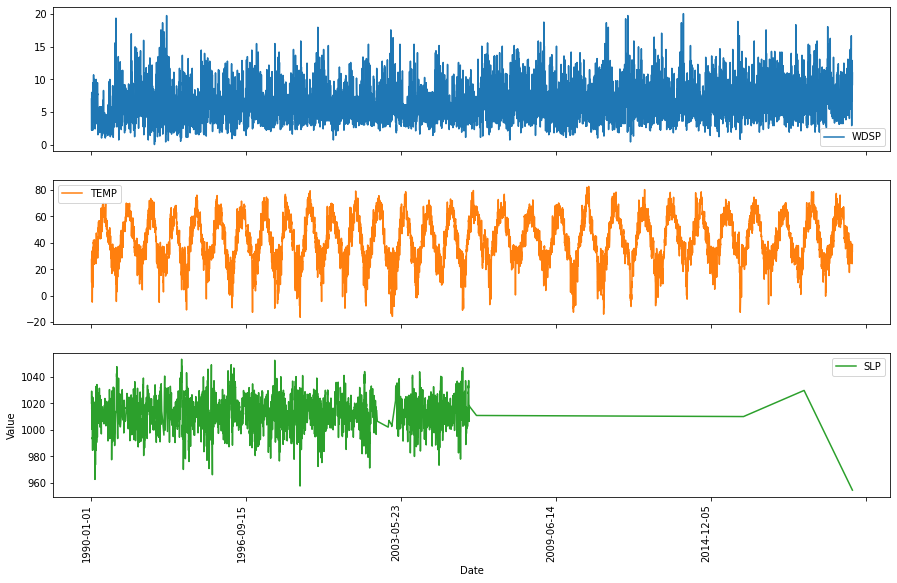

Mean absolute error =  8.5154644943066
Mean squared error =  120.09969293909187


In [313]:
train = pd.concat([X_train, y_train], axis=1)
filled_data = pd.concat([train, missing_vals])
filled_data = filled_data.sort_index()
new_X_train = filled_data[['WDSP', 'TEMP']]
new_y_train = filled_data[['SLP']]

filled_data.plot(subplots=True, figsize=(15, 10))
plt.ylabel("Value")
plt.xlabel("Date")
plt.legend(loc='best')
plt.xticks(rotation='vertical')
plt.show()

model = LinearRegression(normalize=True).fit(new_X_train, new_y_train)
predicted_lr = model.predict(X_test)
mae = mean_absolute_error(y_test, predicted_lr)
mse = mean_squared_error(y_test, predicted_lr)
print('Mean absolute error = ', mae)
print('Mean squared error = ', mse)